# How to Ride the Shopping Cart

## Abstract

Let’s face it: grocery shopping is not a skill most of us intentionally took the time to pursue. However, people more than often find themselves in a situation where they return home with two bags of groceries and realize that they are missing the only item they initially were out for. Sometimes, not having a clear idea about our inventory state, we end up being tempted into the all sorts of treats that are over and above our necessities. Or we buy products to showcase our cooking abilities for the family dinner but somehow we end up with the fridge full of everything, hoping to roll up our sleeves tomorrow. We are often surprised by the amount of items we throw because the expiration date passed two months ago! However, that could change...

## Main Research Question

In this notebook we try to address the following research question:

- Interplay between income and expenses?

### Sub Research Questions

In particular, we are interested in the following sub-questions:

- How do households choose to organize their limited yearly income according to their shopping expenses?

- Can we infer different household types based on the relation between their income and transaction statistics?

- Are some demographic properties of the households indicators of this relation as well i.e. can we infer common family values indirectly from this data?

To begin answering these questions, we first perform data exploration on the **Dunnhumby** dataset to get initial insight for these tasks. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

sns.set(style='whitegrid')

np.set_printoptions(suppress=True)

In [2]:
DATA_DIR = 'data/'

CAMPAIGN_DESC = 'campaign_desc.csv'
CAMPAIGN_TABLE = 'campaign_table.csv'
CAUSAL_DATA = 'causal_data.csv'
COUPON = 'coupon.csv'
COUPON_REDEMPT = 'coupon_redempt.csv'
HH_DEMOGRAPHIC = 'hh_demographic.csv'
PRODUCT = 'product.csv'
TRANSACTION_DATA = 'transaction_data.csv'

## Part 1: Preprocessing

### Loading the Data

For this research question, we only require the `hh_demographic` and `transaction_data` datasets.

In [3]:
df_hh_demographic = pd.read_csv(DATA_DIR + HH_DEMOGRAPHIC, index_col='household_key')

print('Number of households:', len(df_hh_demographic))

df_hh_demographic.head()

Number of households: 801


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


In [4]:
df_transaction_data = pd.read_csv(DATA_DIR + TRANSACTION_DATA, index_col='household_key')

print('Number of transactions:', len(df_transaction_data))

df_transaction_data.head()

Number of transactions: 2595732


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
household_key,,,,,,,,,,,
2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


We observe that the `transaction_data` dataset contains a large number (2.5 mil) of transactions. On the other hand, `transaction_data` dataset is much smaller in size (801).

Furthermore, there are transactions for which demographic data is not present. The reason behind the missing demographic information are privacy issues (as stated in the documentation).

### Handling Missing and Inconsistent Data

In [5]:
print('Columns with missing values in household dataset:', np.any(df_hh_demographic.isna().sum()))
print('Columns with missing values in transactions dataset:', np.any(df_transaction_data.isna().sum()))

Columns with missing values in household dataset: False
Columns with missing values in transactions dataset: False


There are none missing values in both datasets.  

However, in the `transaction_data` dataset we observed that some entries contain 0 for `SALES_VALUE` (the total amount received by the retailer) and for `QUANTITY` (the number of products purchased). There may be a valid reason why the data had been recorded this way, however we chose to avoid any assumptions and discard these transactions, as it is only a small percentage of the whole dataset. 

In [6]:
c = (df_transaction_data['SALES_VALUE'] != 0) & (df_transaction_data['QUANTITY'] != 0)

df_transaction_data_cleaned = df_transaction_data[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 2576815


Following the previous discussion about missing demographic information, we filter the data:

In [7]:
c = df_transaction_data_cleaned.index.isin(df_hh_demographic.index)

df_transaction_data_cleaned = df_transaction_data_cleaned[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 1416672


The `transaction_data` now is half its size before.

**Note**: Although, technically there are none missing values in both datasets, still, the columns: `MARITAL_STATUS_CODE`, `HOMEOWNER_DESC`, and `KID_CATEGORY_DESC` in the `hh_demographic` dataset, take values `U`, `Unknown`, and `None/Unknown` respectively which are unknown values. However, since the columns are categorical, we treat this values as yet another category with hope that later on we can obtain some useful insights.

### Feature Expansion

Using the formulas given in the dataset documentation, we can compute the values most useful for our analysis.

In [8]:
sales_value = df_transaction_data_cleaned['SALES_VALUE']
coupon_desc = df_transaction_data_cleaned['COUPON_DISC']
retail_disc = df_transaction_data_cleaned['RETAIL_DISC']
coupon_match_disc = df_transaction_data_cleaned['COUPON_MATCH_DISC']
quantity = df_transaction_data_cleaned['QUANTITY']

`CUSTOMER_PAID` is how much the customer had to pay as opposed to `PRODUCT_PRICE` which is the actual price of the product.

In [9]:
df_transaction_data_cleaned['CUSTOMER_PAID'] = sales_value + coupon_desc
df_transaction_data_cleaned['PRODUCT_PRICE'] = (sales_value - (retail_disc + coupon_match_disc)) / quantity

### Type Conversion

In [10]:
income_desc_categories = [
    'Under 15K',
    '15-24K',
    '25-34K',
    '35-49K',
    '50-74K',
    '75-99K',
    '100-124K',
    '125-149K',
    '150-174K',
    '175-199K',
    '200-249K',
    '250K+'
]

df_hh_demographic['INCOME_DESC'] = pd.Categorical(df_hh_demographic['INCOME_DESC'],
                                                  categories=income_desc_categories,
                                                  ordered=True)

We could also typecast the other columns, but for now only `INCOME_DESC` is required to perform the analysis.

### What's in the data?

All the columns in the `hh_demographic` are categorical. On the other hand, the columns in `transaction_data` are numerical. More information regarding the value ranges is given in the readme file.

Lets analyse the two derived columns in `transaction_data`: `CUSTOMER_PAID` and `PRODUCT_PRICE`. All the necessary information about a transaction is captured by these two columns. The other columns have data about the basket, time, product, and the retail store, which are not relevant at this moment.

In [11]:
df_transaction_data_cleaned[['CUSTOMER_PAID','PRODUCT_PRICE']].describe().loc[['min', 'max']]

,CUSTOMER_PAID,PRODUCT_PRICE
min,-8.99,0.001759
max,840.00,299.990000


We see that in certain cases the buyer didn't have to pay a penny (why is the amount negative though?) as opposed to cases where the maximum bill amount was as high as \\$840. Also, there is a clear difference between the cheapest and most expensive product bought from the retail store. 

In [12]:
df_transaction_data_cleaned[df_transaction_data_cleaned['CUSTOMER_PAID'] < 0].head()

,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,CUSTOMER_PAID,PRODUCT_PRICE
household_key,,,,,,,,,,,,,
1228,27399113659,36,840938,1,8.99,406,-1.00,2132,6,-9.99,0.00,-1.00,9.99
1228,27399113659,36,881931,1,3.59,406,-0.40,2132,6,-5.99,0.00,-2.40,3.99
2448,27468900591,41,970714,1,0.99,362,-0.40,1257,7,-1.00,0.00,-0.01,1.39
1928,27469012501,41,1092045,1,0.88,330,-0.31,1823,7,-1.00,0.00,-0.12,1.19
979,27469127989,40,1008677,4,1.21,368,0.00,2121,6,-3.08,-0.39,-1.87,0.40


That's the effect of campaigns! We will address this in the other research question.

Lets plot the distributions of `CUSTOMER_PAID` and `PRODUCT_PRICE` (we will work with a sample of 10K elements since the whole dataset contains over 1 mil records and it fails to fit the distributions we assume they are following).

In [13]:
def plot(df, r):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.distplot(df, bins=10, kde=False, ax=ax1)
    ax1.set_xlabel('Value (in $)')
    ax1.set_ylabel('Total')
    sns.distplot(df, bins=10, kde=False, ax=ax2)
    ax2.set_yscale('log')
    ax2.set_xlabel('Value (in $)')
    ax2.set_ylabel('Total')

    xt = ax2.get_xticks()
    xmin, xmax = 0, max(xt)  
    lnspc = np.linspace(xmin, xmax, len(df))
    ax1.set_ylim(top=5000); ax1.set_xlim(right=r)
    ax2.set_ylim(top=5000); ax2.set_xlim(right=r)

    m, s = stats.expon.fit(df)
    pdf_exponential = stats.expon.pdf(lnspc, scale=s)
    sns.lineplot(lnspc, pdf_exponential * len(df), ax=ax1, label='Exponential')
    sns.lineplot(lnspc, pdf_exponential * len(df), ax=ax2, label='Exponential')
    
    a, m, s = stats.powerlaw.fit(df)
    pdf_powerlaw = stats.powerlaw.pdf(lnspc, a, scale=s)
    sns.lineplot(lnspc, pdf_powerlaw * len(df), ax=ax1, label='Powerlaw')
    sns.lineplot(lnspc, pdf_powerlaw * len(df), ax=ax2, label='Powerlaw')

    plt.show()

In [14]:
r = 20
df = df_transaction_data_cleaned['CUSTOMER_PAID'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:5680: RuntimeWarning: divide by zero encountered in power
  return a*x**(a-1.0)


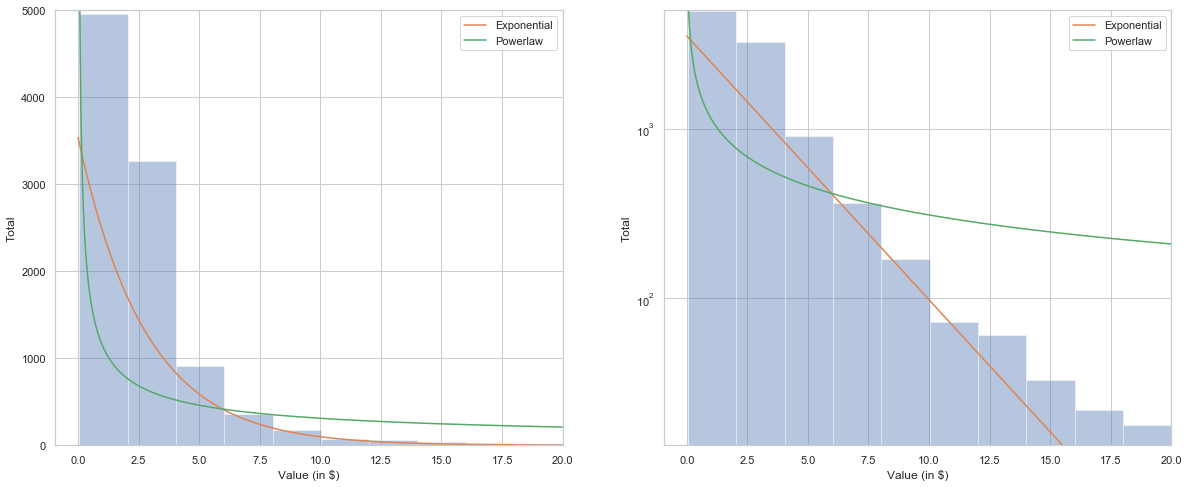

In [15]:
plot(df, r)

In [16]:
r = 20
df = df_transaction_data_cleaned['PRODUCT_PRICE'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

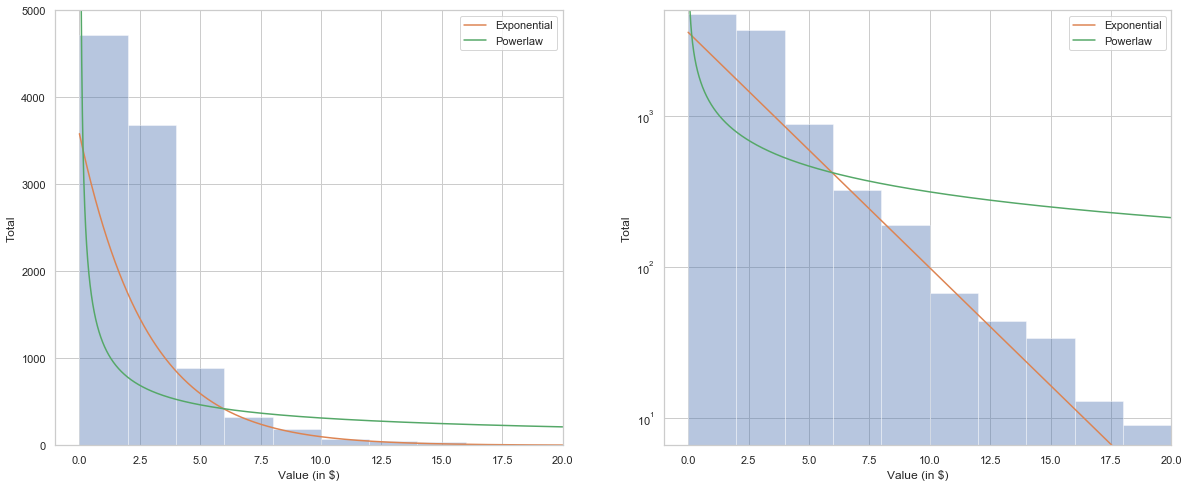

In [17]:
plot(df, r)

Looks like we have an exponential distribution for both columns.

### Joining Datasets

We join the two datasets to obtain the transactions for each household. 

In [18]:
df_households_transactions = df_transaction_data_cleaned.join(df_hh_demographic)

print('Total number of transactions for the selected households:', len(df_households_transactions))

Total number of transactions for the selected households: 1416672


## Part 2: Data Analysis

### Analysis of the Underlying Distributions

The following analysis can help us discover the shopping habits of the households, regardless of their annual income.

#### Household Income

The main feature of each household which we will analyze is the `INCOME_DESC` column. It holds information about the total anual income for each household. The main challenge in answering our question is the fact that this feature is non numeric - each income value is represented as a category which represents an interval of income values. Looking on the bright side, there is meaningful ordering of the categories as they are intervals. 

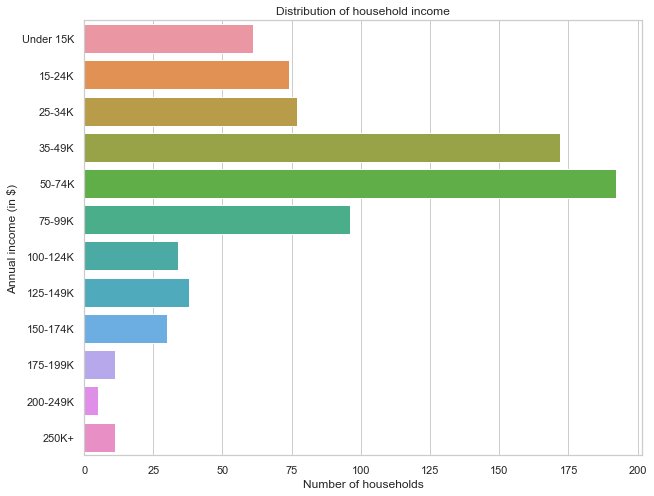

In [19]:
f, ax = plt.subplots(figsize=(10, 8))

income_desc = df_hh_demographic['INCOME_DESC'].value_counts()
sns.barplot(x=income_desc, y=income_desc.index, ax=ax)
ax.set_title('Distribution of household income')
ax.set_xlabel('Number of households')
ax.set_ylabel('Annual income (in $)')

plt.show()

Looking at the barplot depicting the distribution of this feature we notice hints of a (bimodal) Gaussian distribution, however the discretization makes it impossible to verify.

#### Average Bill Amount

To measure the spending habits of the households, we compute the average amount of households' bills. Each household visit to a store is uniquely identified with a `BASKET_ID`. We do this in two steps:

1. We sum the derived `CUSTOMER_PAID` column across the transactions for each visit to get the total bill amount for the visit. <br>
2. We average across all visits of each household.

In [20]:
df_households_basket_payment = df_households_transactions.groupby(['household_key', 'BASKET_ID'])['CUSTOMER_PAID'].sum()
df_households_basket_payment_average = df_households_basket_payment.groupby(['household_key']).mean()

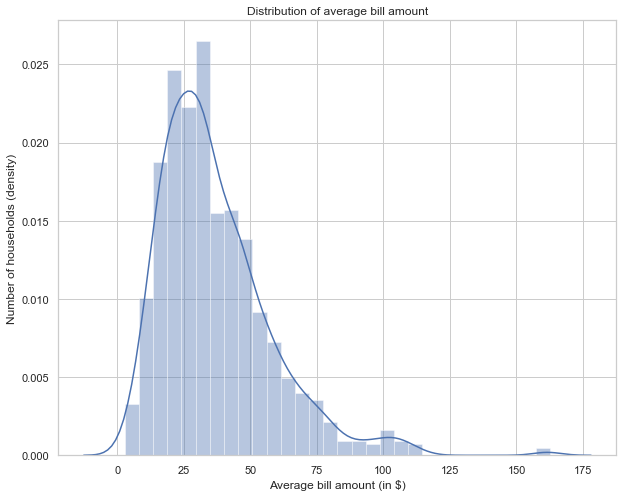

In [21]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_payment_average)
ax.set_title('Distribution of average bill amount')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

Looking at the histogram of this statistic, we identify it as a right-skewed Gaussian distribution, with a few outliers.

#### Average Price of the Most Expensive Product

From another perspective, we can calculate a different statistic quantifying the spending habits of each household. This time we use the derived `PRODUCT_PRICE` to calculate the maximum product price in each basket and then average across for each household. 

In [22]:
df_households_basket_max_product_price = df_households_transactions.groupby(['household_key', 'BASKET_ID'])['PRODUCT_PRICE'].max()
df_households_basket_max_product_price_average = df_households_basket_max_product_price.groupby('household_key').mean()

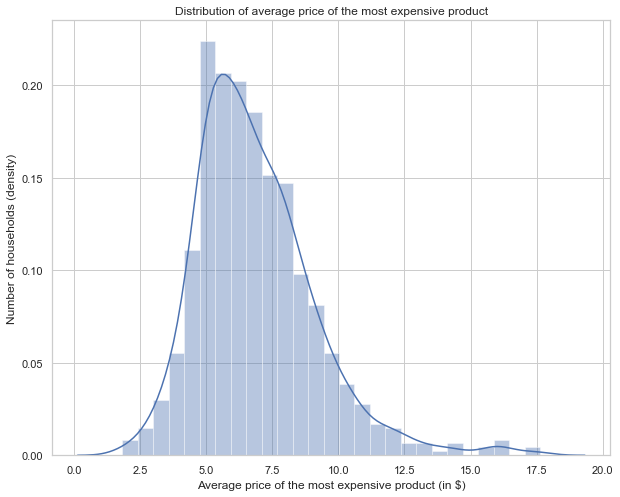

In [23]:
f, ax = plt.subplots(figsize=(10, 8))

sns.distplot(df_households_basket_max_product_price_average)
ax.set_title('Distribution of average price of the most expensive product')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Number of households (density)')

plt.show()

We observe from its histogram that this feature has a much more regular Gaussian distribution.

### Statistics Comparison

#### Correlation

Using a scatter plot, we would like to see it the two statistics are coorelated.

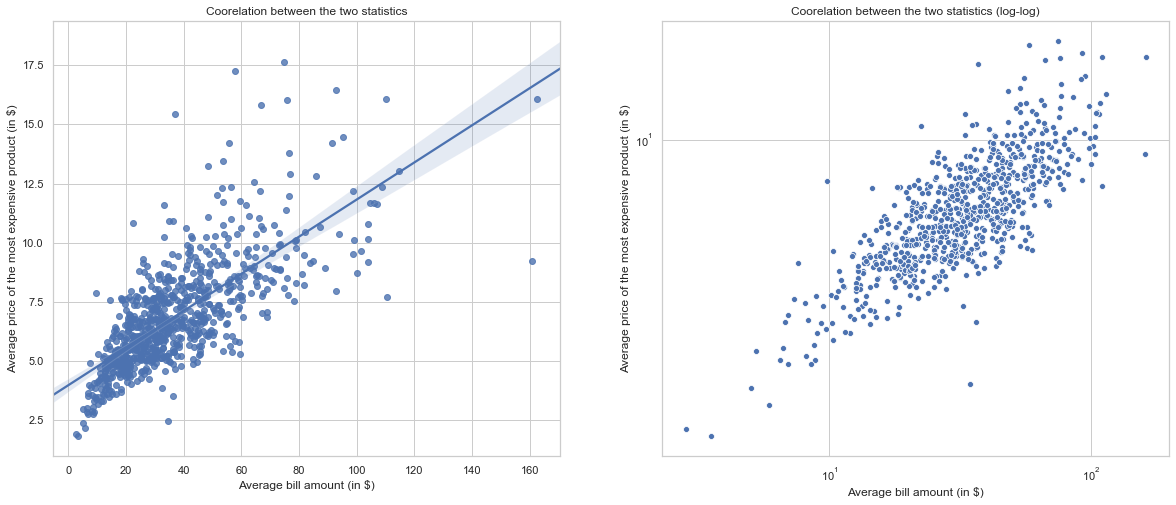

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.regplot(df_households_basket_payment_average, df_households_basket_max_product_price_average, ax=ax1)
ax1.set_title('Coorelation between the two statistics')
ax1.set_xlabel('Average bill amount (in $)')
ax1.set_ylabel('Average price of the most expensive product (in $)')

sns.scatterplot(df_households_basket_payment_average, df_households_basket_max_product_price_average, ax=ax2)
ax2.set_title('Coorelation between the two statistics (log-log)')
ax2.set_xlabel('Average bill amount (in $)')
ax2.set_ylabel('Average price of the most expensive product (in $)')
ax2.set(xscale='log', yscale='log')

plt.show()

In [25]:
df_households_basket_payment_average.corr(df_households_basket_max_product_price_average, method='spearman')

0.7564947649602585

When using linear scales one can see an incrising monotonic associacion. Additionally, when viewing the data on log-log scales we can discern a linear trend, with large variance.

This suggests that the statistics might be almost equivalent (after some nonlinear transformation) and can be used interchangeably. We will support this further with the analyses in the following sections.

### Analysis of the Joint Distribution 

#### Household Income vs. Average Bill Amount

Using a boxplot we can view the distribution of the statistic across each household income category and perform a comparison very efficiently.

In [26]:
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_payment_average)

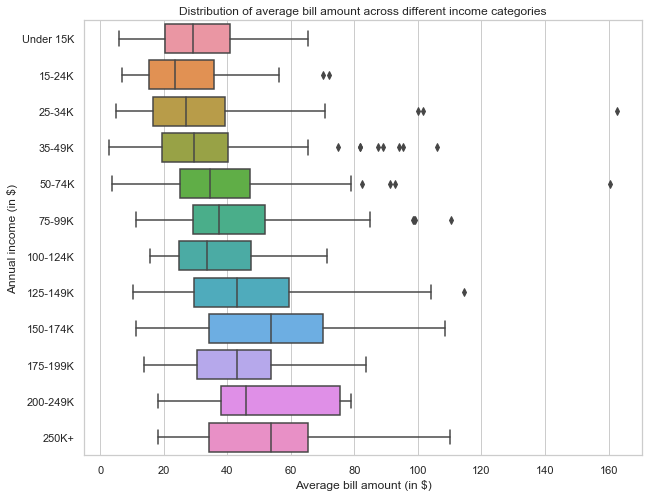

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='CUSTOMER_PAID', y='INCOME_DESC', data=df)
ax.set_title('Distribution of average bill amount across different income categories')
ax.set_xlabel('Average bill amount (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

To our surprise, extreme spending are mostly observed for medium and lower income households.

Using a 2D histogram i.e. heatmap we can compare the relationship between income and the statistic in more detail by viewing their joint distribution.

In [28]:
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))

df['INCOME_DESC'] = df['INCOME_DESC'].astype(str).map(mapping)

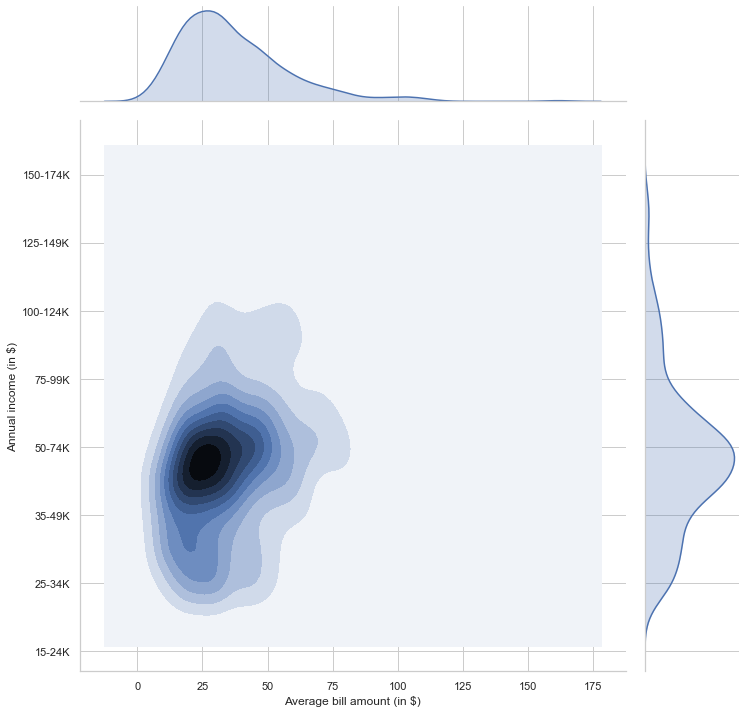

In [29]:
g = sns.jointplot(y='INCOME_DESC', x='CUSTOMER_PAID', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average bill amount (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

We can observe that the majority of the households are concentrated at the medium income values of 35-74K and lower average expenses of about \\$20 - \\$40.

#### Household Income vs. Average Price of the Most Expensive Product

Similarly, to begin the comparison between household income and maximum product prices we first merge the two features of each household.

In [30]:
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_max_product_price_average)

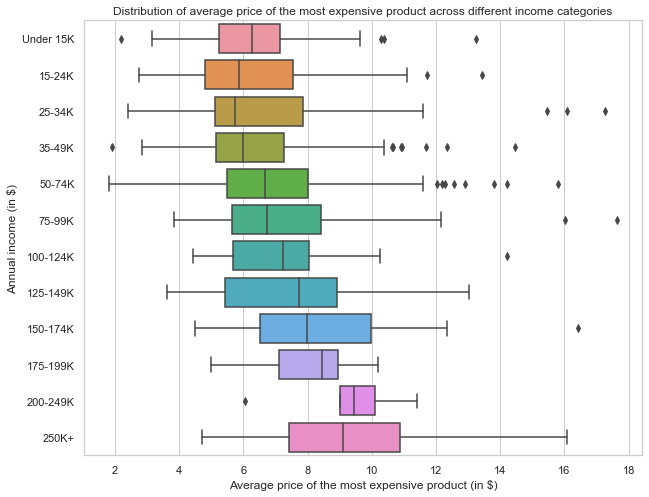

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.boxplot(x='PRODUCT_PRICE', y='INCOME_DESC', data=df)
ax.set_title('Distribution of average price of the most expensive product across different income categories')
ax.set_xlabel('Average price of the most expensive product (in $)')
ax.set_ylabel('Annual income (in $)')

plt.show()

The phenomena related to the extreme values is present here as well. Additionally, an interesting difference is the huge range of values for the richest households, perhaps capturing the fact that these households mostly purchase the most expensive products.

In [32]:
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))

df['INCOME_DESC'] = df['INCOME_DESC'].astype(str).map(mapping)

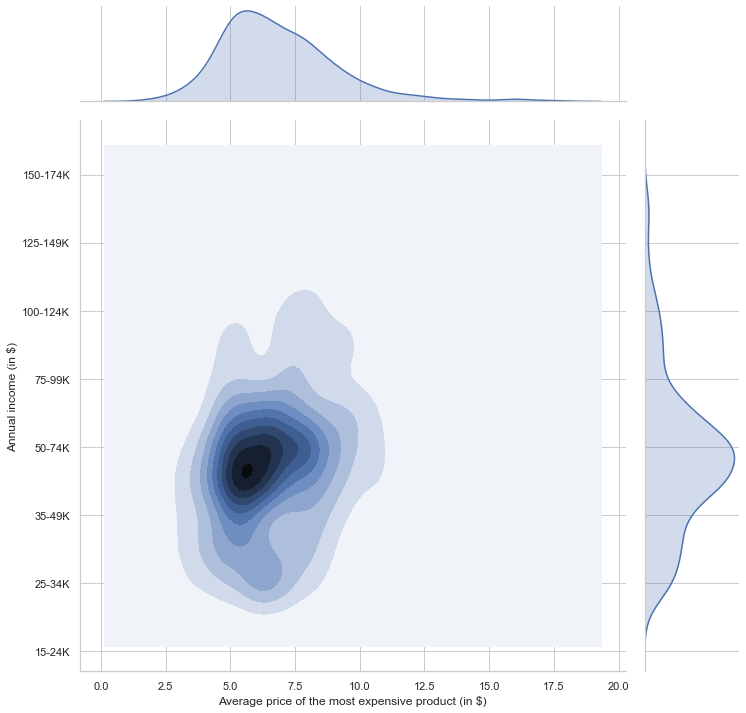

In [33]:
g = sns.jointplot(y='INCOME_DESC', x='PRODUCT_PRICE', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average price of the most expensive product (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);

Analyzing the joint distribution using the jointplot, we observe that it is very similar in form to the one for the previous statistic, further proving their equivalence.

## Trends

#### Expenses

In [108]:
df = df_households_transactions.groupby(['household_key', 'DAY'])['CUSTOMER_PAID'].sum().reset_index()
df_top_buyers = df.groupby('household_key')['CUSTOMER_PAID'].sum().sort_values(ascending=False)
df_top_buyers.head(10)

household_key
1609    27801.54
2322    23629.32
1453    21590.16
1430    20319.99
707     19185.57
1653    19125.47
718     19049.02
982     18633.37
400     18449.64
1229    18275.01
Name: CUSTOMER_PAID, dtype: float64

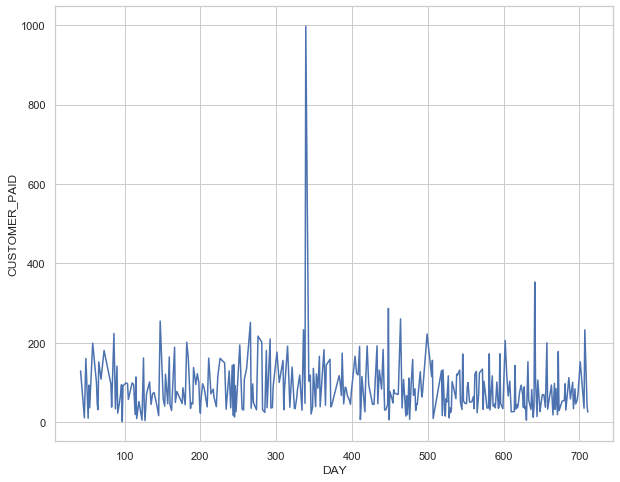

In [109]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.lineplot(x='DAY', y='CUSTOMER_PAID', data=df[df['household_key'] == 1609])

plt.show()

In [110]:
df_hh_demographic.loc[1609]

AGE_DESC                       45-54
MARITAL_STATUS_CODE                A
INCOME_DESC                 125-149K
HOMEOWNER_DESC             Homeowner
HH_COMP_DESC           2 Adults Kids
HOUSEHOLD_SIZE_DESC               5+
KID_CATEGORY_DESC                 3+
Name: 1609, dtype: object

In [111]:
dff = df[df['household_key'] == 1609]
dff.loc[dff['CUSTOMER_PAID'].idxmax()]

household_key    1609.00
DAY               339.00
CUSTOMER_PAID     997.51
Name: 74483, dtype: float64

In [122]:
df_transaction_data_cleaned[df_transaction_data_cleaned['DAY'] == 339].loc[1609]

,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,CUSTOMER_PAID,PRODUCT_PRICE
household_key,,,,,,,,,,,,,
1609,32006114302,339,825731,1,2.50,412,-0.29,2038,49,0.0,0.0,2.50,2.790000
1609,32006114302,339,838971,1,4.99,412,-0.40,2038,49,0.0,0.0,4.99,5.390000
1609,32006114302,339,853354,1,1.99,412,0.00,2038,49,0.0,0.0,1.99,1.990000
1609,32006114302,339,862725,2,4.98,412,0.00,2038,49,0.0,0.0,4.98,2.490000
1609,32006114302,339,866211,1,4.04,412,0.00,2038,49,0.0,0.0,4.04,4.040000
1609,32006114302,339,885309,1,3.19,412,0.00,2038,49,0.0,0.0,3.19,3.190000
1609,32006114302,339,907309,1,2.50,412,-1.19,2038,49,0.0,0.0,2.50,3.690000
1609,32006114302,339,909714,1,1.81,412,-0.89,2038,49,0.0,0.0,1.81,2.700000
1609,32006114302,339,927325,1,5.09,412,-1.02,2038,49,0.0,0.0,5.09,6.110000


#### Mapping Between Expenses and Product Categories

Here we are interested to find out how household expenditure depends on the goods and/or services and how does it vary with household income. For this analysis, we will load the `product.csv` dataset. It contains information about a particular product associated with a transaction.

In [319]:
df_product = pd.read_csv(DATA_DIR + PRODUCT, index_col='PRODUCT_ID')

print('Number of products:', len(df_product))

df_product.head()

Number of products: 92353


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
PRODUCT_ID,,,,,,
25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [320]:
print('Columns with missing values in products dataset:',
      np.any(df_product.isna().sum()))

Columns with missing values in products dataset: False


We join the household transactions dataset with the products dataset using the `PRODUCT_ID` column.

In [331]:
df_transactions_products = \
    df_households_transactions[['PRODUCT_ID', 'QUANTITY', 'CUSTOMER_PAID', 'INCOME_DESC']] \
    .join(df_product[['COMMODITY_DESC', 'SUB_COMMODITY_DESC']], on='PRODUCT_ID')

df_transactions_products.head()

,PRODUCT_ID,QUANTITY,CUSTOMER_PAID,INCOME_DESC,COMMODITY_DESC,SUB_COMMODITY_DESC
household_key,,,,,,
1,825123,1,3.99,35-49K,SALD DRSNG/SNDWCH SPRD,SEMI-SOLID SALAD DRESSING MAY
1,831447,1,2.99,35-49K,CHEESE,SHREDDED CHEESE
1,840361,1,1.09,35-49K,EGGS,EGGS - LARGE
1,845307,1,3.71,35-49K,DELI MEATS,MEAT: TURKEY BULK
1,852014,1,2.79,35-49K,ICE CREAM/MILK/SHERBTS,TRADITIONAL


The following dataset is just an aggregate over `INCOME_DESC` and `COMMODITY_DESC`. It is usefull for our analysis that follow.

In [322]:
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True)['CUSTOMER_PAID'] \
    .sum() \
    .dropna() \
    .to_frame()

df.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

#### Most Purchased Product Category

In [323]:
df.unstack().idxmax(axis=1)

INCOME_DESC
Under 15K    (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
15-24K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
25-34K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
35-49K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
50-74K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
75-99K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
100-124K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
125-149K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
150-174K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
175-199K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
200-249K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
250K+        (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
dtype: object

In [324]:
stats = df.unstack() \
    ['CUSTOMER_PAID']['GASOLINE-REG UNLEADED'].values

stats

array([ 27538.22,  21220.85,  28143.44,  68745.23, 103028.78,  51419.37,
        25482.19,  31439.02,  25289.36,   8126.89,    558.06,   4226.57])

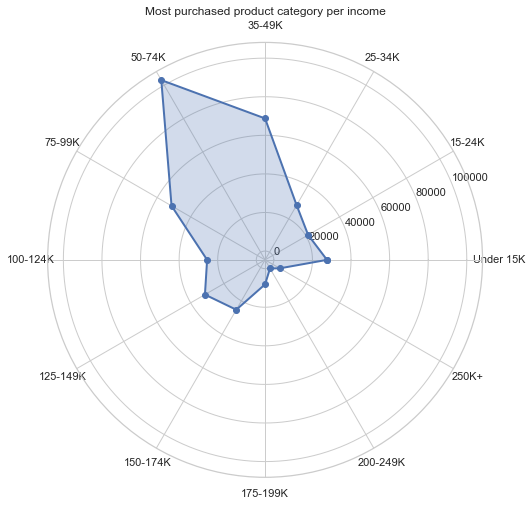

In [325]:
angles = np.linspace(0, 2 * np.pi, len(income_desc_categories), endpoint=False)
stats = np.concatenate((stats, [stats[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

ax.plot(angles, stats, 'o-', linewidth=2)
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.set_title('Most purchased product category per income')
ax.grid(True)

plt.show()

Here we see that households, intependent of their anual income, spend most of their money on gasoline, which is expected. There is a high discrepancy between the product for which the households spend most of their money and the next one, which is not surprising since the `CUSTOMER_PAID` follows an exponential distribution. Setting gasoline aside, we are also interest in how the expenses are distributed in the other product categories.

In [326]:
dff = df[df.index.get_level_values('SUB_COMMODITY_DESC') != 'GASOLINE-REG UNLEADED']

dff.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

For this, we will use a sankey plot because it is an excelent way to visualise flow of information between two subsets. From it, we will have a clear idea about how the expenses from income groups map to product categories.

We will use top 200 products ordered by `QUANTITY` plot the flow diagram between the income and the product category. We can easily visualise how the quantity of the purchased products is distributed and later search for patterns in the expenditure.

In [327]:
dff = dff \
    .reset_index() \
    .sort_values(by='CUSTOMER_PAID', ascending=False) \
    .head(100)

In [328]:
data = []

palette = sns.color_palette('cubehelix', len(dff) + dff['INCOME_DESC'].nunique())
colours = palette.as_hex()

level1 = dff[['INCOME_DESC', 'CUSTOMER_PAID']] \
    .groupby('INCOME_DESC', observed=True) \
    .agg('sum')

c_count = 0

for i, r in level1.reset_index().iterrows():
    data.append({
        'source': 'Expenditure',
        'target': r['INCOME_DESC'],
        'value': r['CUSTOMER_PAID'],
        'color': colours[c_count]
    })
    
    item_dff = dff[dff['INCOME_DESC'] == r['INCOME_DESC']] \
        [['INCOME_DESC', 'SUB_COMMODITY_DESC', 'CUSTOMER_PAID']] \
        .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True) \
        .agg('sum') \
        .reset_index()
    
    for item_i, item_r in item_dff.iterrows():
        
        c_count += 1

        data.append({
            'source': item_r['INCOME_DESC'],
            'target': item_r['SUB_COMMODITY_DESC'],
            'value': item_r['CUSTOMER_PAID'],
            'color': colours[c_count]
        })

In [316]:
w = SankeyWidget(layout=Layout(width='1600', height='3000'),
                 links=data,
                 margins=dict(top=0, bottom=0, left=100, right=150))

w

SankeyWidget(layout=Layout(height='3000', width='1600'), links=[{'source': 'Expenditure', 'target': 'Under 15K…

#### Engel curves

One particular way of determining how household expenditure, on a particular good or service, varies with household income is visualising Engel curves. Engel curves on the x-axis have the income category and on the y-axis the quantity of the measured product. We can infer some type of goods using these curves.

In [332]:
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'COMMODITY_DESC'], observed=True)['QUANTITY'] \
    .sum() \
    .dropna() \
    .reset_index()

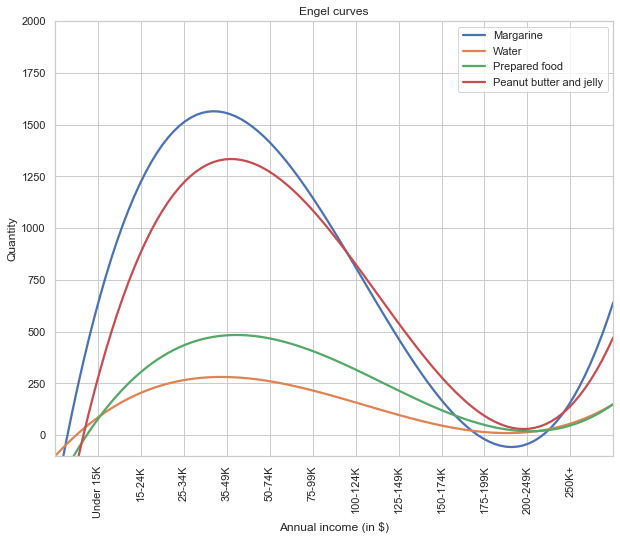

In [333]:
fig, ax = plt.subplots(figsize=(10, 8))

x = np.arange(len(income_desc_categories))
ax.set_xlim(left=-1, right=12)
ax.set_ylim(bottom=-100, top=2000)

sns.regplot(x=x, y='QUANTITY', data=df.query('COMMODITY_DESC == "MARGARINES"'), order=3, scatter=False, ci=None, ax=ax, label='Margarine')
sns.regplot(x=x, y='QUANTITY', data=df.query('COMMODITY_DESC == "WATER"'), order=3, scatter=False, ci=None, ax=ax, label='Water')
sns.regplot(x=x, y='QUANTITY', data=df.query('COMMODITY_DESC == "PREPARED FOOD"'), order=3, scatter=False, ci=None, ax=ax, label='Prepared food')
sns.regplot(x=x, y='QUANTITY', data=df.query('COMMODITY_DESC == "PNT BTR/JELLY/JAMS"'), order=3, scatter=False, ci=None, ax=ax, label='Peanut butter and jelly')
ax.set_xticks(x)
ax.set_xticklabels(income_desc_categories, rotation='vertical')
ax.set_title('Engel curves')
ax.set_xlabel('Annual income (in $)')
ax.set_ylabel('Quantity')

plt.legend()
plt.show()

Here we showcase an example of inferior goods. Margaring is an inferior good since its demand drops when people's incomes rise. This occurs when a good has more costly substitutes (butter) that see an increase in demand as incomes and the economy improve. There are other examples in our dataset (ex. water, prepared food, peanut butter and jelly). It is a little problematic to visualise this curve since our `INCOME_DESC` column is categorical, but fitting a third order (or even second order) polynomial confirms its existence. We can use this information to further classify our households by expenditure.

### Demographic Analysis of Household Groups

In order to understand how family values influence the balance between household's expenses and income, we will analyze the demographic properties across 4 groups of households.

In [43]:
AVG_INCOME = '50-74K'
AVG_EXPENSES = 32.2431

In [44]:
df = df_hh_demographic.join(df_households_basket_payment_average.to_frame().rename(columns={'CUSTOMER_PAID': 'EXPENSES'}))

df_low_income_low_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_low_income_high_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]
df_high_income_low_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_high_income_high_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]

In [45]:
print('Percent of households with low income and low expenses:', round(len(df_low_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with low income and high expenses:', round(len(df_low_income_high_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and low expenses:', round(len(df_high_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and high expenses:', round(len(df_high_income_high_expenses) / len(df_hh_demographic), 4))

Percent of households with low income and low expenses: 0.4082
Percent of households with low income and high expenses: 0.3109
Percent of households with high income and low expenses: 0.0924
Percent of households with high income and high expenses: 0.1885


These groups were generated using the average income and average expenses. We split the households into: below (or above) average income and below (or above) average expenses.

In [46]:
def plot_demographic(column_name, demographic_categories, demographic_feature_name):
    df = pd.concat([
        df_low_income_low_expenses[column_name].value_counts().rename('Low/ Low') / len(df_low_income_low_expenses),
        df_low_income_high_expenses[column_name].value_counts().rename('Low/ High') / len(df_low_income_high_expenses),
        df_high_income_low_expenses[column_name].value_counts().rename('High/ Low') / len(df_high_income_low_expenses),
        df_high_income_high_expenses[column_name].value_counts().rename('High/ High') / len(df_high_income_high_expenses)
    ], axis=1, sort=False)
    df.index = demographic_categories
    df = df.unstack().reset_index()
    df.columns = ['Income vs. Expenses', demographic_feature_name, 'Percentage of households']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    sns.barplot(x=demographic_feature_name, y='Percentage of households', hue='Income vs. Expenses', data=df)
    ax.set_title(f'Demographic analysis of household groups - {demographic_feature_name}')
    
    plt.show()

#### Age

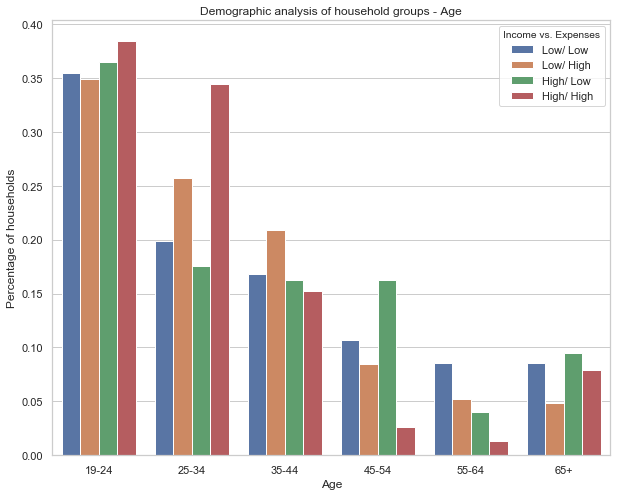

In [47]:
column_name = 'AGE_DESC'
demographic_categories = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']
demographic_feature_name = 'Age'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

From the age distribution of the household groups, we can make a few interesting observations. Among the households with the youngest members there is not a lot of variety in the income-expenses balance. Among the households with members of younger working ages high expenses seem to dominate. As we move to the households with older members lower expenses are more prevalent.

#### Martial Status

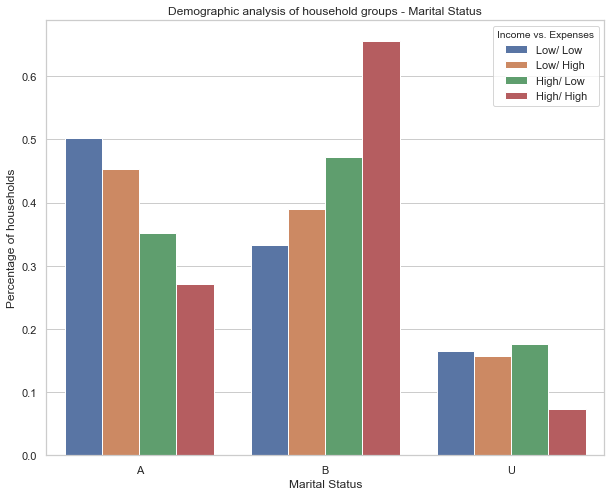

In [48]:
column_name = 'MARITAL_STATUS_CODE'
demographic_categories = ['A', 'B', 'U']
demographic_feature_name = 'Marital Status'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

For clarification, according to the dataset documentation the marital status codes `A`, `B`, and `U` stand for `Married`, `Single` and `Unknown` respectively. Interestingly, this plot efficiently captures classical differences between married and single life, as we observe that households with married members have more often lower income and must balance with lower expenses, while it is completely opposite for single member households, as they more frequently have higher income and are able to indulge in higher expenses.  

#### Homeowner Type

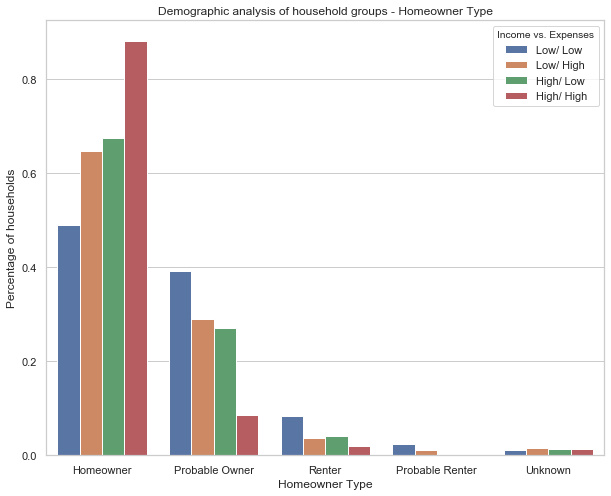

In [49]:
column_name = 'HOMEOWNER_DESC'
demographic_categories = ['Homeowner', 'Probable Owner', 'Renter', 'Probable Renter', 'Unknown']
demographic_feature_name = 'Homeowner Type'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Analyzing the distribution of the type of homeownership we again obtain expected results, as it is understandable that it is most probable for households who are able to afford their own place of residence to have higher income and expenses, while renters usually have better sense of utilizing their limited income. 

#### Household Composition

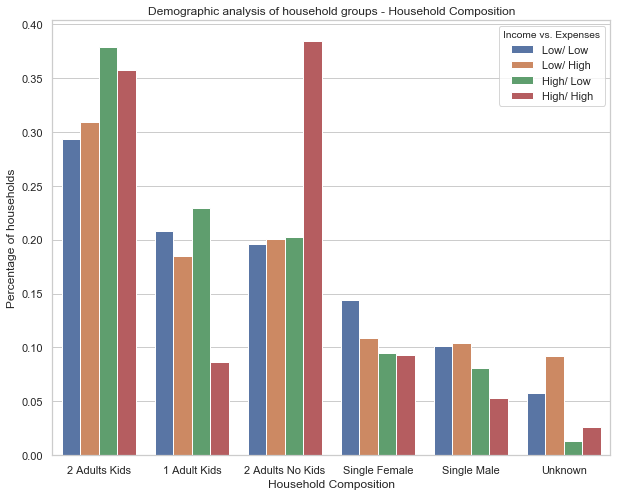

In [50]:
column_name = 'HH_COMP_DESC'
demographic_categories = ['2 Adults Kids', '1 Adult Kids', '2 Adults No Kids', 'Single Female', 'Single Male', 'Unknown']
demographic_feature_name = 'Household Composition'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

Among the different household compositions recorded in the data, we do not observe a lot of variety and this feature is not a good discriminator. However, we do observe two interesting discrepancies which can also be expected: couples with no children have the highest chance to be in the group with the highest income and expenses, while single parents have a harder time.

#### Household Size

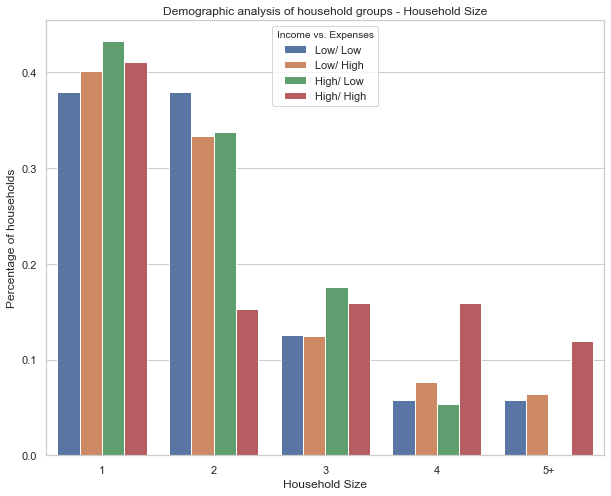

In [51]:
column_name = 'HOUSEHOLD_SIZE_DESC'
demographic_categories = ['1', '2', '3', '4', '5+']
demographic_feature_name = 'Household Size'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The household size feature also displays very little significance for group distinction across different values. However, we can observe a trend that as the household size increases the probability of having lower income and expenses decreases, as only households with higher income can afford to have more children, but with that their expenses also increase.

#### Number of Children

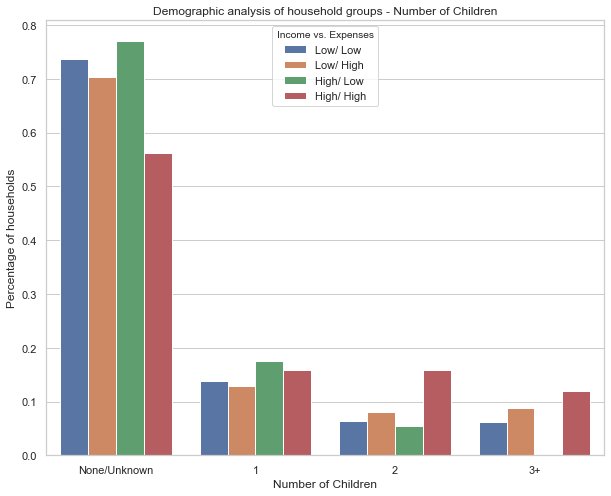

In [52]:
column_name = 'KID_CATEGORY_DESC'
demographic_categories = ['None/Unknown', '1', '2', '3+']
demographic_feature_name = 'Number of Children'

plot_demographic(column_name, demographic_categories, demographic_feature_name)

The demographic records for the number of children can be inferred from previous features such as household size and household composition and as such in the plot we observe a similar trend as in the previous analysis of household size.

## Part 3: Applied ML

We are interested in whether there is existence of clusters in `hh_demographic` dataset. Since all the columns are categorical, we first transform the dataset using one-hot-encoding per column. Then, we apply PCA to project the dataset into 2 dimensional space, and finally apply KMeans clustering.

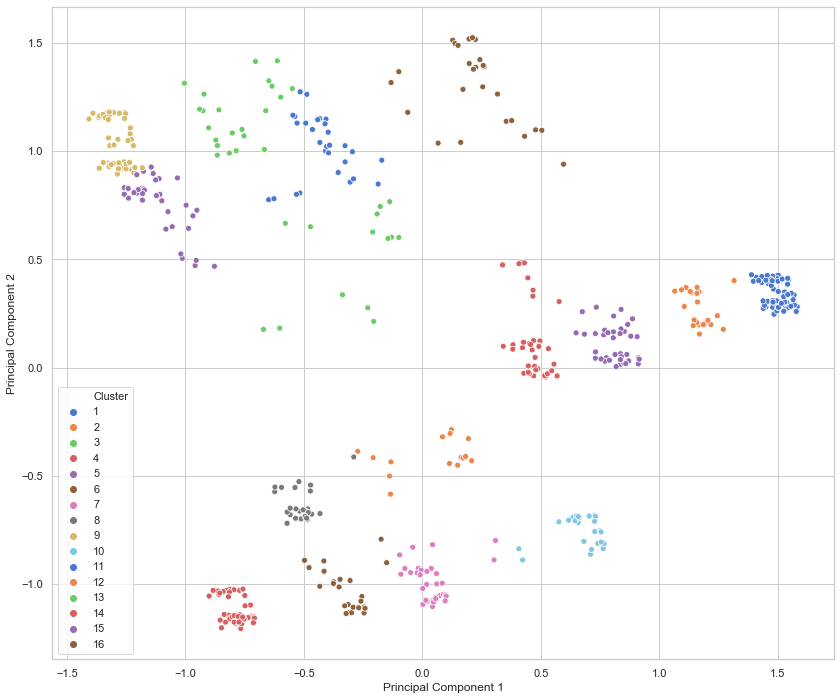

In [53]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

c = (df_hh_demographic['MARITAL_STATUS_CODE'] != 'U') & \
    (df_hh_demographic['HOMEOWNER_DESC'] != 'Unknown') & \
    (df_hh_demographic['KID_CATEGORY_DESC'] != 'None/Unknown')

k = 16

X = pd.get_dummies(df_hh_demographic)

pca = PCA(n_components=2).fit_transform(X)

kmeans = KMeans(n_clusters=k).fit(pca)

df = pd.DataFrame(np.concatenate((pca, kmeans.labels_.reshape(-1, 1)+1), axis=1), columns=['Principal Component 1', 'Principal Component 2', 'Cluster'])
df['Cluster'] = df['Cluster'].astype(int)

f, ax = plt.subplots(figsize=(14, 12))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2',  data=df, hue='Cluster', palette=sns.color_palette('muted', n_colors=k))
plt.show()

Although, PCA is hard to interpret, however, in the graph above we can see that there are 16 distinguishable clusters. This might suggest of cluster existence in higher dimensions and we will use this information for further insights.

## Part 4: Recap and Future Steps